In [1]:
import sys
import os
import pandas as pd
sys.path.append('/Users/rishabhbhardwaj/Documents/personal/courses/cse6250/project/Chest-XRay-Classification/')

In [13]:
from keras.models import load_model
from keras.preprocessing import image
from src.models import DenseNet, ModelFactory
import numpy as np
import keras
from sklearn.metrics.ranking import roc_auc_score
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

In [25]:
img_width, img_height = 224, 224
model_file_path = '/Users/rishabhbhardwaj/Documents/personal/courses/cse6250/project/Chest-XRay-Classification/codalab/src/best_weights_1555982768.7076797.h5'
model_file_path2 = '/Users/rishabhbhardwaj/Documents/personal/courses/cse6250/project/new_checkout/ChestXRay-Classification/weights/best_weights_1556219541.2163985_NASNet.h5'
data_dir = '/Users/rishabhbhardwaj/Documents/personal/courses/cse6250/project/'
valid_file = os.path.join(data_dir, 'CheXpert-v1.0-small/valid.csv')
# model_file_path = '../weights/best_weights_1555865398.1238055_Apr22_5cls.h5'
class_names = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']
model_type = "DenseNet121"

In [6]:
model_factory = ModelFactory()
model = model_factory.get_model( class_names,
                                model_name=model_type,
                                use_base_weights=True,
                                weights_path=model_file_path,
                                input_shape=(img_height, img_width, 3))
optimizer = keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

load model weights_path /Users/rishabhbhardwaj/Documents/personal/courses/cse6250/project/Chest-XRay-Classification/codalab/src/best_weights_1555982768.7076797.h5


In [26]:
model2 = model_factory.get_model( class_names,
                                model_name='NASNetLarge',
                                use_base_weights=True,
                                weights_path=model_file_path2,
                                input_shape=(331, 331, 3))
model2.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

343613440/343610240 [==============================] - 91s 0us/step
load model weights_path /Users/rishabhbhardwaj/Documents/personal/courses/cse6250/project/new_checkout/ChestXRay-Classification/weights/best_weights_1556219541.2163985_NASNet.h5


In [7]:
from src.generator import CheXpertDataGenerator
valid_data = CheXpertDataGenerator(dataset_csv_file=valid_file,
            class_names=class_names,
            source_image_dir=data_dir,
            batch_size=1,
            target_size=(224, 224),
            augmenter=None,
            policy ='mixed',
        )

/Users/rishabhbhardwaj/Documents/personal/courses/cse6250/project/Chest-XRay-Classification/src/generator.py:73: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.x_path, y_df = df["Path"].as_matrix(), df[self.class_names]


In [28]:
valid_data2 = CheXpertDataGenerator(dataset_csv_file=valid_file,
            class_names=class_names,
            source_image_dir=data_dir,
            batch_size=1,
            target_size=(331, 331),
            augmenter=None,
            policy ='mixed',
        )

/Users/rishabhbhardwaj/Documents/personal/courses/cse6250/project/Chest-XRay-Classification/src/generator.py:73: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.x_path, y_df = df["Path"].as_matrix(), df[self.class_names]


In [8]:
pred = model.predict_generator(valid_data)

In [29]:
pred_nasnet = model2.predict_generator(valid_data2)

In [9]:
df = pd.read_csv(valid_file)
df = df[df['Frontal/Lateral']=='Frontal']
class_df = df[class_names]
gt = class_df.as_matrix()

/anaconda2/envs/cse6250/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [10]:
def computeAUROC (dataGT, dataPRED, classCount):
    outAUROC = []
    for i in range(classCount):
        try:
            outAUROC.append(roc_auc_score(dataGT[:, i], dataPRED[:, i]))
        except ValueError:
            pass
    return outAUROC

In [11]:
aurocIndividual = computeAUROC(gt, pred, 5)
aurocMean = np.array(aurocIndividual).mean()
print ('AUROC mean ', aurocMean)
for i in range (0, len(aurocIndividual)):
    print (class_names[i], ' ', aurocIndividual[i])

AUROC mean  0.48077689331389084
Atelectasis   0.5191601049868766
Cardiomegaly   0.500222816399287
Consolidation   0.46341911764705884
Edema   0.4635416666666667
Pleural Effusion   0.45754076086956524


In [32]:
aurocIndividual2 = computeAUROC(gt, pred_nasnet, 5)
aurocMean2 = np.array(aurocIndividual2).mean()
print ('AUROC mean ', aurocMean2)
for i in range (0, len(aurocIndividual2)):
    print (class_names[i], ' ', aurocIndividual2[i])

AUROC mean  0.49085273939179486
Atelectasis   0.5373228346456692
Cardiomegaly   0.5222816399286987
Consolidation   0.46452205882352937
Edema   0.4351190476190476
Pleural Effusion   0.49501811594202905


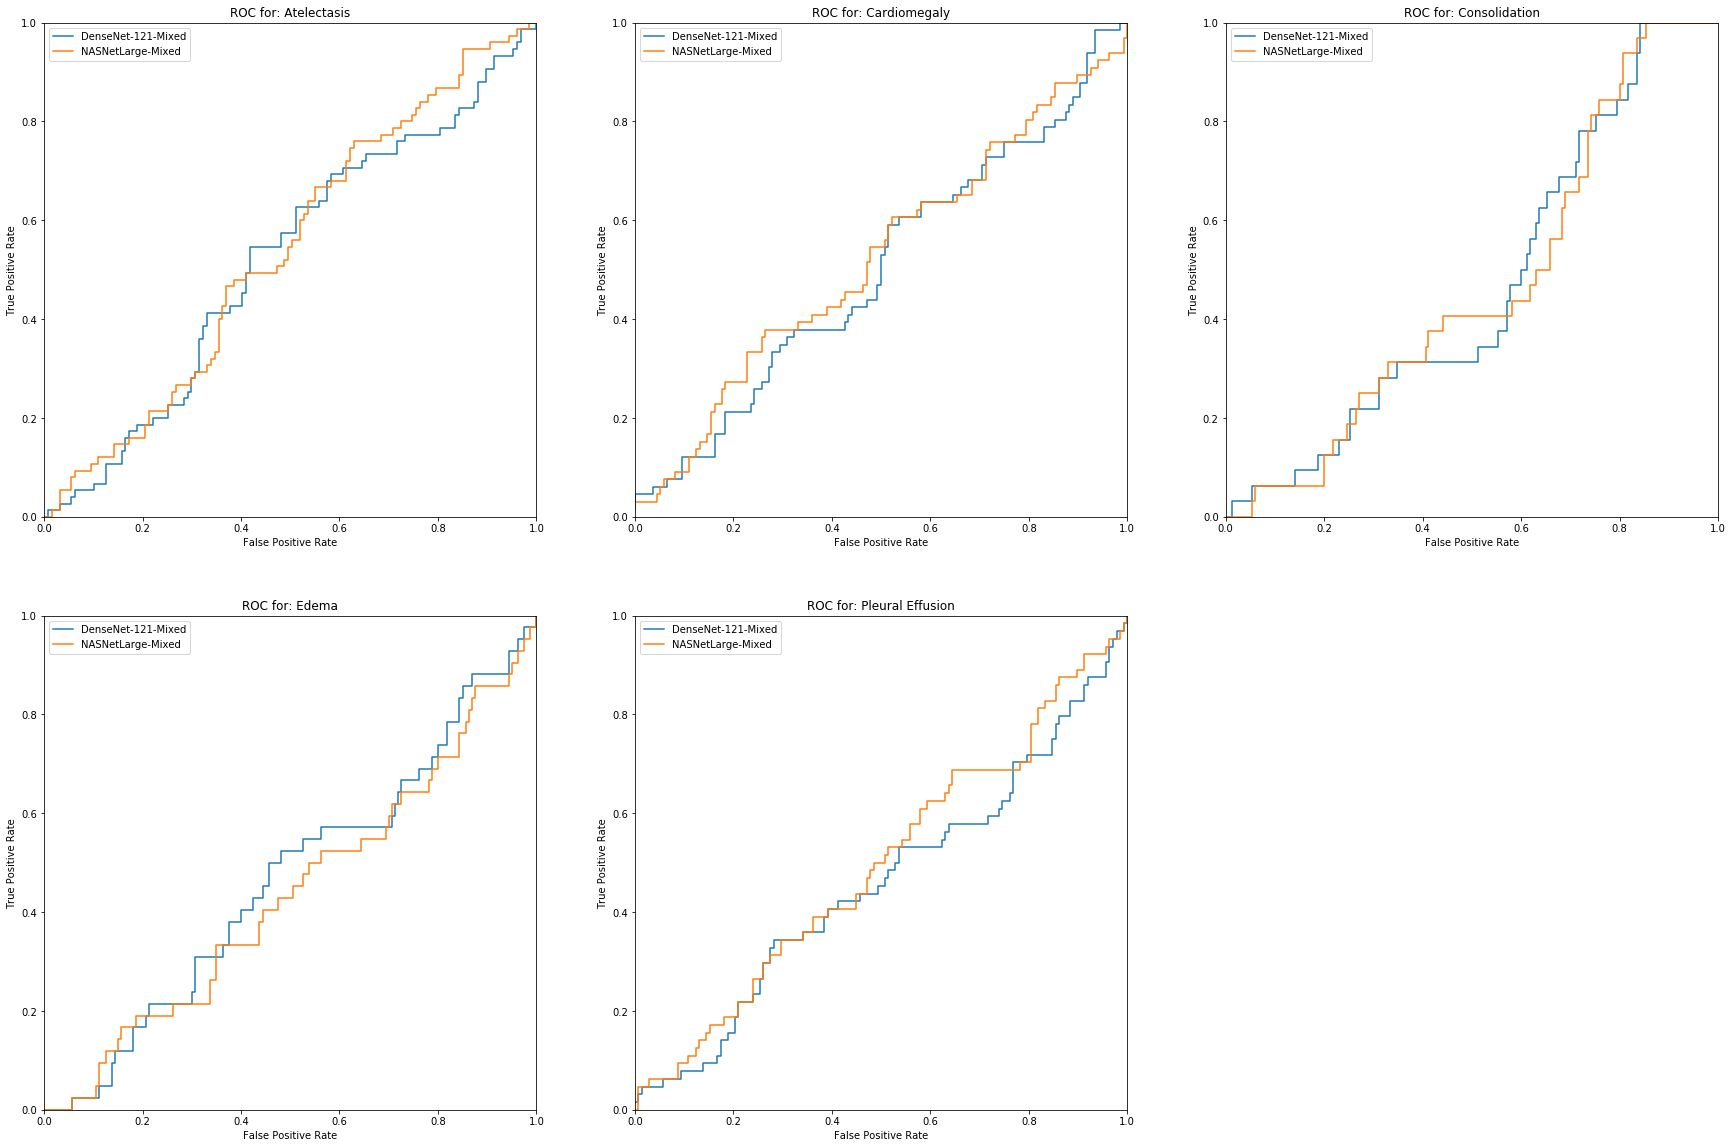

In [59]:
nnClassCount = 5
for i in range(nnClassCount):
    p1, r1, th1 = metrics.roc_curve(gt[:,i], pred[:,i])
    p2, r2, th1 = metrics.roc_curve(gt[:,i], pred_nasnet[:,i])
    roc_auc = metrics.auc(r1, p1)
    f = plt.subplot(2, 3, i+1)
    
    plt.title('ROC for: ' + class_names[i])
    plt.plot(p1, r1, label = 'DenseNet-121-Mixed')
    plt.plot(p2, r2, label = 'NASNetLarge-Mixed')
    plt.legend()
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

plt.savefig("DenseNet121-NASNet_5_class_AUC.png")
plt.show()